In [1]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch


KeyboardInterrupt: 

In [22]:
import os
import re
import numpy as np
from datetime import datetime
from torch.utils.data import Dataset
import rasterio
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [18]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm

from src.models import PConvUNet2D
from src.data import TempoInpaintDataset, Normalizer, load_classification_pickle
from src.losses import calculate_metrics, warmup_loss
from src.utils import visualize_batch, _add_shape
# save_classification_pickle(complete, partial, blank, output_file="file_classification_nop.pkl")
complete, partial, blank = load_classification_pickle()
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'

z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)

normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/hpc/home/srs108/TEMPO/cus/cb_2018_us_state_500k.shp"

# train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files)
# val_ds = TempoInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files)
# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from scipy.ndimage import gaussian_filter

def generate_realistic_gaps_simple(shape, tempo_mask, n_blobs=5, blob_size_range=(80, 200), threshold=0.5):
    """
    Generate realistic cloud-like gap patterns using multi-scale blobs
    
    Parameters:
    - shape: (ny, nx) shape of the output
    - tempo_mask: boolean array where True indicates valid TEMPO pixels
    - n_blobs: number of large-scale cloud structures
    - blob_size_range: tuple of (min, max) blob sizes
    - threshold: threshold for creating gaps (lower = more gaps)
    """
    ny, nx = shape
    field = np.zeros((ny, nx))
    
    # Get valid pixel locations
    valid_locs = np.where(tempo_mask)
    if len(valid_locs[0]) == 0:
        # No valid pixels, return empty mask
        return np.zeros(shape, dtype=np.float32)
    
    # Large-scale cloud structures - more elongated
    for _ in range(n_blobs):
        # Random blob center from valid locations only
        idx = np.random.randint(0, len(valid_locs[0]))
        cy = valid_locs[0][idx]
        cx = valid_locs[1][idx]
        
        # Random blob size (much larger)
        blob_size = np.random.randint(*blob_size_range)
        
        # Create elongated cloud-like blob
        y, x = np.ogrid[:ny, :nx]
        
        # Make more elongated by reducing aspect ratio range
        angle = np.random.uniform(0, 2*np.pi)
        aspect_ratio = np.random.uniform(0.1, 0.4)  # More elongated (was 0.3, 1.0)
        
        # Rotate coordinates
        y_rot = (y - cy) * np.cos(angle) - (x - cx) * np.sin(angle)
        x_rot = (y - cy) * np.sin(angle) + (x - cx) * np.cos(angle)
        
        # Create highly elliptical blob
        blob = np.exp(-(y_rot**2 / (2 * (blob_size/1.5)**2) + 
                       (x_rot * aspect_ratio)**2 / (2 * (blob_size/4)**2)))
        
        # Add to field with random intensity
        field += blob * np.random.uniform(0.8, 1.5)
    
    # Add medium-scale details - also elongated
    for _ in range(n_blobs * 2):
        # Random center from valid locations
        idx = np.random.randint(0, len(valid_locs[0]))
        cy = valid_locs[0][idx]
        cx = valid_locs[1][idx]
        
        blob_size = np.random.randint(40, 100)
        
        y, x = np.ogrid[:ny, :nx]
        
        # Make medium blobs elongated too
        angle = np.random.uniform(0, 2*np.pi)
        aspect_ratio = np.random.uniform(0.02, 0.06)
        
        y_rot = (y - cy) * np.cos(angle) - (x - cx) * np.sin(angle)
        x_rot = (y - cy) * np.sin(angle) + (x - cx) * np.cos(angle)
        
        blob = np.exp(-(y_rot**2 / (2 * (blob_size/3)**2) + 
                       (x_rot * aspect_ratio)**2 / (2 * (blob_size/5)**2)))
        
        field += blob * np.random.uniform(0.3, 0.8)
    
    # Add fine-scale texture
    for _ in range(n_blobs * 4):
        # Random center from valid locations
        idx = np.random.randint(0, len(valid_locs[0]))
        cy = valid_locs[0][idx]
        cx = valid_locs[1][idx]
        
        blob_size = np.random.randint(15, 40)
        
        y, x = np.ogrid[:ny, :nx]
        blob = np.exp(-((y - cy)**2 + (x - cx)**2) / (2 * (blob_size/5)**2))
        field += blob * np.random.uniform(0.1, 0.5)
    
    # Apply stronger Gaussian smoothing for more diffuse appearance
    field = gaussian_filter(field, sigma=5)
    
    # Add some noise for more realistic texture
    noise = np.random.normal(0, 0.1, field.shape)
    field += gaussian_filter(noise, sigma=3)
    
    # Normalize and apply threshold
    field = (field - field.min()) / (field.max() - field.min())
    gap_mask = (field < threshold).astype(np.float32)
    
    # Constrain gaps to only occur where TEMPO pixels are valid
    gap_mask = gap_mask * tempo_mask.astype(np.float32)
    
    return gap_mask

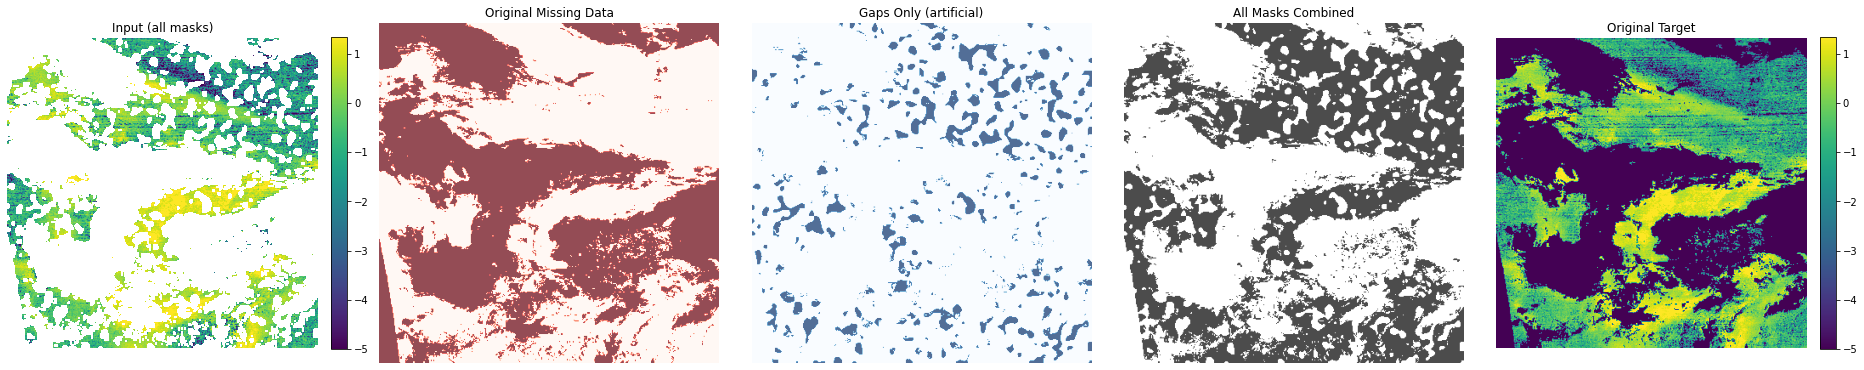

Original missing data: 73506 pixels
Gaps only (artificial in known areas): 17193 pixels
All artificial holes: 90699 pixels
Total holes: 90699 pixels
Gap percentage of known data: 19.9%


In [60]:
class TempoInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None):
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # store and index files by timestamp
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        # sort by time (keep a parallel array of paths)
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]

    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT


#     def sample_vis(self, idx=None, train=None):
#         if idx is None:
#             idx = np.random.randint(len(self))

#         # Use the dataset's train flag if not explicitly provided
#         if train is None:
#             train = self.train

#         sample = self[idx]

#         inp_np = sample["masked_img"][0].numpy()
#         mask_obs = sample["known_mask"][0].numpy().astype(bool)
#         targ = sample['target'][0].numpy()

#         # Calculate vmin/vmax for consistent scaling
#         vmin, vmax = np.percentile(targ[np.isfinite(targ)], [2, 98])
#         cmap_v = plt.cm.viridis.copy()
#         cmap_v.set_bad("white")

#         if train:
#             # Training dataset: show all 5 panels
#             mask_sp = sample['fake_mask'][0].numpy().astype(bool)
#             mask_eff = sample["known_and_fake_mask"][0].numpy().astype(bool)


#             fig, ax = plt.subplots(1, 5, figsize=(22, 6))

#             # Panel 1: Input (masked with effective mask)
#             im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_eff), 
#                               cmap=cmap_v, vmin=vmin, vmax=vmax)
#             ax[0].set_title("Input (masked)")
#             fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

#             # Panel 2: Observed holes (sensor missing data)
#             ax[1].imshow(mask_obs == 0, cmap="Reds", alpha=0.7)
#             ax[1].set_title("Observed Holes (sensor)")

#             # Panel 3: Artificial holes (salt & pepper)
#             ax[2].imshow(mask_sp == 0, cmap="Blues", alpha=0.7)
#             ax[2].set_title("Artificial Holes")

#             # Panel 4: Combined mask (both types of holes)
#             ax[3].imshow(mask_eff == 0, cmap="gray", alpha=0.7)
#             ax[3].set_title("Both Masks (used in training)")

#             # Panel 5: Original target (complete image)
#             im4 = ax[4].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
#                               cmap=cmap_v, vmin=vmin, vmax=vmax)
#             ax[4].set_title("Regular Input")
#             fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

#             for a in ax: 
#                 a.axis("off")
#             plt.tight_layout()
#             plt.show()

#             # Print some statistics
#             temp_mask = np.sum(mask_obs)
#             if 'fake_mask' in sample:
#                 added_mask = np.sum(mask_sp)
#                 print(f"Original holes: {(~mask_obs).sum()} pixels")
#                 print(f"Artificial holes: {(~mask_sp).sum()} pixels") 
#                 print(f"Total holes: {(~mask_eff).sum()} pixels")

#         else:
#             # Validation dataset: show only 3 panels
#             fig, ax = plt.subplots(1, 3, figsize=(15, 6))

#             # Panel 1: Input (masked with observed holes only)
#             im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_obs),cmap=cmap_v, vmin=vmin, vmax=vmax)
#             ax[0].set_title("Input (masked)");fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

#             # Panel 2: Observed holes (sensor missing data)
#             ax[1].imshow(mask_obs == 0, cmap="Reds", alpha=0.7)
#             ax[1].set_title("Observed Holes (sensor)")

#             # Panel 3: Original target (complete image)
#             im2 = ax[2].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),cmap=cmap_v, vmin=vmin, vmax=vmax)
#             ax[2].set_title("Regular Input");fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

#             for a in ax: 
#                 a.axis("off")
#             plt.tight_layout()
#             plt.show()

#             # Print statistics
#             print(f"Observed holes: {(~mask_obs).sum()} pixels")
#             print(f"Total pixels: {mask_obs.size}")
#             print(f"Hole percentage: {100 * (~mask_obs).sum() / mask_obs.size:.1f}%")

            
            
    def sample_vis(self, idx=None, train=None):
        if idx is None:
            idx = np.random.randint(len(self))

        # Use the dataset's train flag if not explicitly provided
        if train is None:
            train = self.train

        sample = self[idx]

        inp_np = sample["masked_img"][0].numpy()
        known_mask = sample["known_mask"][0].numpy().astype(bool)
        all_masks = sample["known_and_fake_mask"][0].numpy().astype(bool)
        targ = sample['target'][0].numpy()

        # Calculate vmin/vmax for consistent scaling
        vmin, vmax = np.percentile(targ[np.isfinite(targ)], [2, 98])
        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")

        if train:
            # For training dataset, we have the realistic gaps
            realistic_gaps = sample['fake_mask'][0].numpy().astype(bool)

            # SEPARATE THE GAPS: Extract only the gap pixels (not the original missing data)
            gaps_only_mask = known_mask & (~realistic_gaps)  # Areas that are known but made into gaps

            fig, ax = plt.subplots(1, 5, figsize=(26, 6))

            # Panel 1: Input (masked with all masks)
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~all_masks), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax)
            ax[0].set_title("Input (all masks)")
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Panel 2: Original missing data (sensor holes)
            ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
            ax[1].set_title("Original Missing Data")

            # Panel 3: GAPS ONLY (artificial holes in previously known areas)
            ax[2].imshow(gaps_only_mask, cmap="Blues", alpha=0.7)
            ax[2].set_title("Gaps Only (artificial)")


            # Panel 4: Combined mask (all holes)
            ax[3].imshow(all_masks == 0, cmap="gray", alpha=0.7)
            ax[3].set_title("All Masks Combined")

            # Panel 6: Original target
            im4 = ax[4].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax)
            ax[4].set_title("Original Target")
            fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

            for a in ax: 
                a.axis("off")
            plt.tight_layout()
            plt.show()

            # Print statistics
            original_missing = (~known_mask).sum()
            gaps_only = gaps_only_mask.sum()
            all_artificial = (~realistic_gaps).sum()
            total_holes = (~all_masks).sum()

            print(f"Original missing data: {original_missing} pixels")
            print(f"Gaps only (artificial in known areas): {gaps_only} pixels")
            print(f"All artificial holes: {all_artificial} pixels")
            print(f"Total holes: {total_holes} pixels")
            print(f"Gap percentage of known data: {100 * gaps_only / known_mask.sum():.1f}%")

        else:
            # Validation dataset: show only 3 panels (no artificial gaps)
            fig, ax = plt.subplots(1, 3, figsize=(15, 6))

            # Panel 1: Input (masked with known mask only)
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~known_mask), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax)
            ax[0].set_title("Input (original mask)")
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Panel 2: Original missing data
            ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
            ax[1].set_title("Original Missing Data")

            # Panel 3: Original target
            im2 = ax[2].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax)
            ax[2].set_title("Original Target")
            fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

            for a in ax: 
                a.axis("off")
            plt.tight_layout()
            plt.show()

            # Print statistics
            print(f"Original missing data: {(~known_mask).sum()} pixels")
            print(f"Total pixels: {known_mask.size}")
            print(f"Missing percentage: {100 * (~known_mask).sum() / known_mask.size:.1f}%")
        
    # ---------- torch Dataset API ----------
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):     
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 
    
    
    
        if self.train:
            n_blobs= np.random.randint(0,5)
            realistic_gaps = generate_realistic_gaps_simple(
                                    shape=(H, W), 
                                    tempo_mask=(known_mask),  # Your TEMPO valid pixel mask
                                    n_blobs=n_blobs, 
                                    blob_size_range=(20, 74),  # Can make even larger
                                    threshold=0.6
                                )

            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks

            sample = {
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       # mask used in training, 
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),          # salt/pepper holes
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                "path": path,
            }
            return sample

        else:
            sample = {
                "masked_img": torch.from_numpy(img_n).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                "path": path}
        
            return sample
train_ds = TempoInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=True,file_list=val_files)
train_ds.sample_vis(train=True)

  0%|          | 0/1043 [00:00<?, ?it/s]

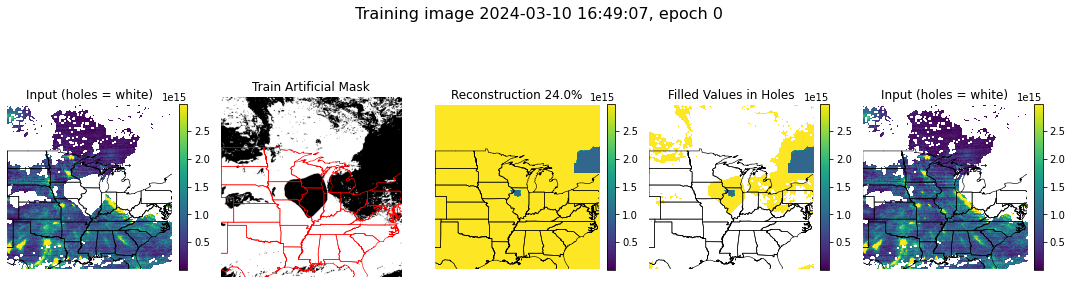

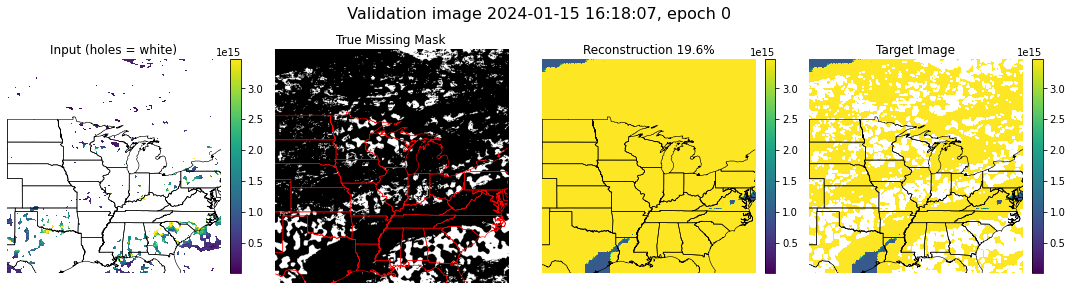

  0%|          | 1/1043 [00:06<1:57:04,  6.74s/it]

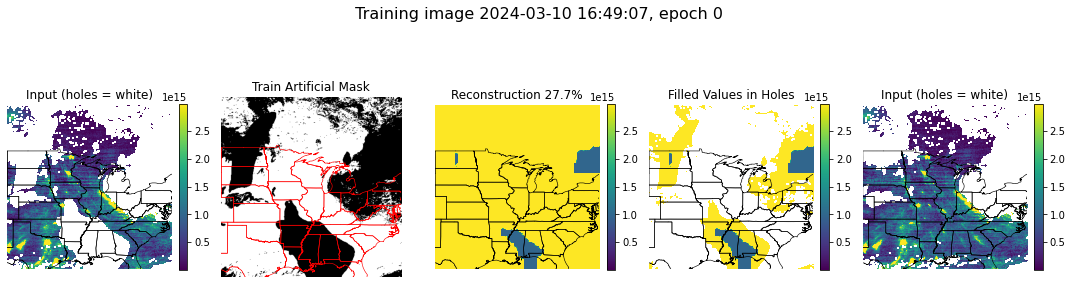

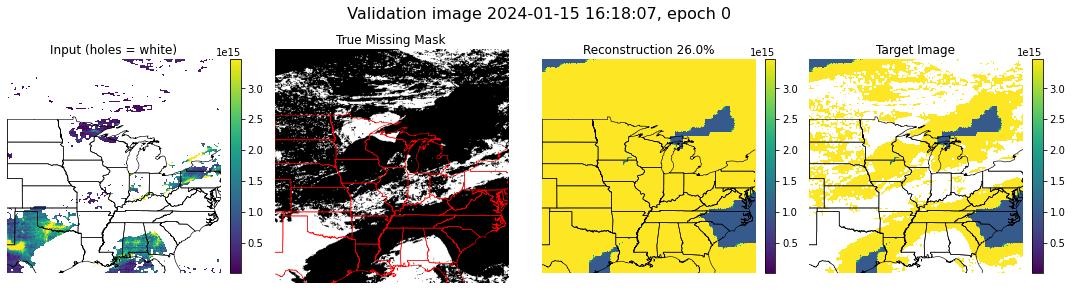

  0%|          | 2/1043 [00:13<1:57:26,  6.77s/it]

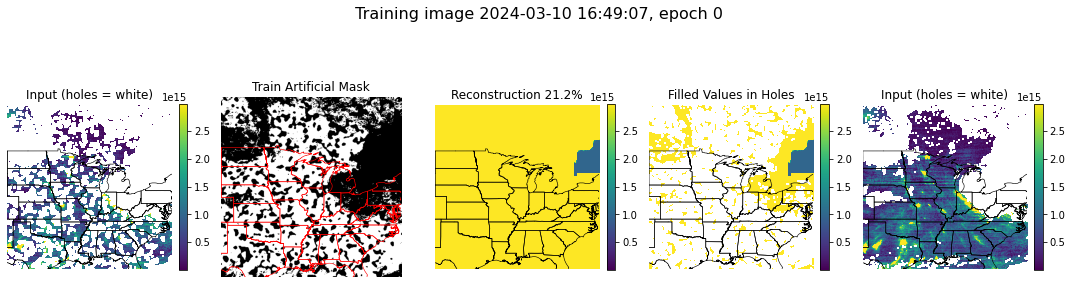

  0%|          | 2/1043 [00:18<2:39:08,  9.17s/it]


KeyboardInterrupt: 

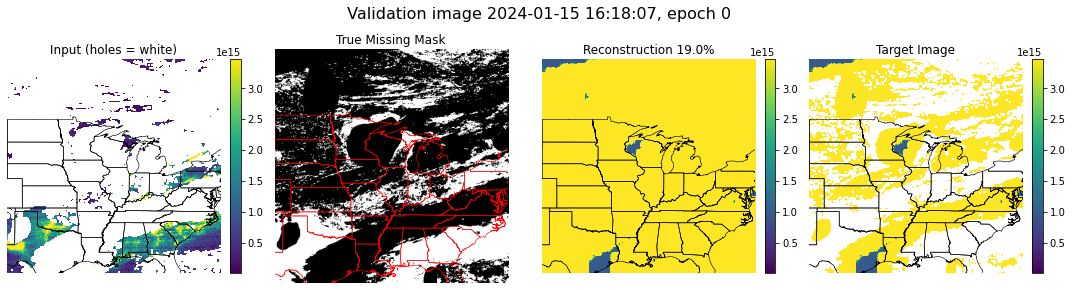

In [12]:
def train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    wait = 0

    history = []
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["img_w_both_masks"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            target = batch["target"].cuda()

            pred_t, pred_mask = model(img, mask_aug)
            loss = warmup_loss(pred_t, target, mask)            
            
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
            
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(pred_t, target, mask_aug)
            for key in batch_metrics:
                train_metrics[key] += batch_metrics[key]
            batch_count += 1
            visualize_batch(epoch, model,normalizer, train_ds, idx=300, device="cuda",train=True, shp_path=shp_path,save=True)
            visualize_batch(epoch, model, normalizer, val_ds, idx=19, device="cuda", train=False, shp_path=shp_path,save = True)

        # Average metrics over batches
        train_loss /= len(train_loader)
        for key in train_metrics:
            train_metrics[key] /= batch_count

        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["img_w_both_masks"].cuda()
                mask = batch["known_and_fake_mask"].cuda()
                mask_aug = batch["fake_mask"].cuda()  # Add this line to get fake mask
                target = batch["target"].cuda()
                pred, pred_mask = model(img, mask)

                loss = warmup_loss(pred, target, mask)
                val_loss += loss.item()
                
                # Calculate metrics for fake mask regions
                batch_metrics = calculate_metrics(pred, target, mask_aug)
                for key in batch_metrics:
                    val_metrics[key] += batch_metrics[key]
                batch_count += 1
                
        val_loss /= len(val_loader)
        for key in val_metrics:
            val_metrics[key] /= batch_count
    
        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")
        print(f"Val metrics - RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}, R²: {val_metrics['r2']:.4f}")
        
                    
        
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "val_rmse": val_metrics['rmse'],
            "val_mae": val_metrics['mae'],
            "val_r2": val_metrics['r2'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        })
        
        with open('csv_history.csv', "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=[
                "epoch", "train_loss", "val_loss", 
                "train_rmse", "train_mae", "train_r2",
                "val_rmse", "val_mae", "val_r2",
                "pred_min_range", "pred_max_range"
            ])
            writer.writeheader()
            writer.writerows(history)
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=150, patience=20)